# Install libraries, packages and dataset

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Configurations

In [2]:
train_folder_path = 'D:/Desktop/Face Expression using PyTorch/Face-Expression-using-PyTorch/Dataset/train'
validation_folder_path = 'D:/Desktop/Face Expression using PyTorch/Face-Expression-using-PyTorch/Dataset/validation'

lr=0.0001
batches=32
epochs=10

device = 'cpu'
model_name = 'efficientnet_b0'

# Load Dataset

In [3]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T

In [4]:
train_augs = T.Compose([
   T.RandomHorizontalFlip(p=0.5),
   T.RandomRotation(degrees=(-20,20)),
   T.ToTensor()
])

valid_augs = T.Compose([
   T.ToTensor()
])

In [5]:
trainset = ImageFolder(train_folder_path, transform=train_augs)
validset = ImageFolder(validation_folder_path, transform=valid_augs)

In [6]:
print(f"Total no. of examples in trainset : {len(trainset)}")
print(f"Total no. of examples in validset : {len(validset)}")

Total no. of examples in trainset : 28821
Total no. of examples in validset : 7066


In [7]:
print(trainset.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


Text(0.5, 1.0, '2')

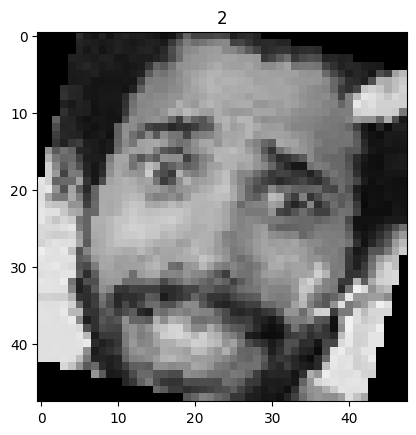

In [8]:
image, label = trainset[6390]

plt.imshow(image.permute(1,2,0))
plt.title(label)

# Load Dataset into Batches

In [9]:
from torch.utils.data import DataLoader

In [10]:
trainloader = DataLoader(trainset, batch_size= batches, shuffle=True)
validloader = DataLoader(validset, batch_size= batches)

In [11]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 901
Total no. of batches in validloader : 221


In [12]:
for images, labels in trainloader:
	break

print(f"One image batch shape : {images.shape}")
print(f"One label batch shape : {labels.shape}")

One image batch shape : torch.Size([32, 3, 48, 48])
One label batch shape : torch.Size([32])


# Create Model

In [13]:
import timm
from torch import nn

In [14]:
class FaceModel(nn.Module):
	def __init__(self):
		super(FaceModel, self).__init__()
		self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True, num_classes=7)
      
	def forward(self, images, labels=None):
		logits = self.efficientnet(images)

		if labels != None:
			loss = nn.CrossEntropyLoss()(logits, labels)
			return logits, loss
		
		return logits

In [15]:
import torch
print(torch.cuda.is_available())  # Should be True if CUDA is enabled
print(torch.version.cuda)         # Shows the CUDA version PyTorch was built with

False
None


In [16]:
model = FaceModel()
model.to(device)

FaceModel(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw):

# Create Train and Eval Function

In [17]:
from tqdm import tqdm

In [18]:
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [19]:
def train_fn(model, dataloader, optimizer, current_epo):
	model.train()
	total_loss=0.0
	total_acc=0.0
	tk = tqdm(dataloader, desc = "EPOCH" + "[TRAIN]" + str(current_epo + 1) + "/`" + str(epochs))
   
	for t, data in enumerate(tk):
		images, labels =data
		images, labels = images.to(device), labels.to(device)

		optimizer.zero_grad()
		logits, loss = model(images, labels)
		loss.backward()
		optimizer.step()

		total_loss+=loss.item()
		total_acc+=multiclass_accuracy(logits, labels)
		tk.set_postfix(loss = total_loss/(t+1),accuracy = total_acc/(t+1))

	return total_loss/len(dataloader), total_acc/len(dataloader)

In [20]:
def eval_fn(model, dataloader, current_epo):
	model.eval()
	total_loss=0.0
	total_acc=0.0
	tk = tqdm(dataloader, desc = "EPOCH" + "[VALID]" + str(current_epo + 1) + "/`" + str(epochs))
   
	for t, data in enumerate(tk):
		images, labels =data
		images, labels = images.to(device), labels.to(device)

		logits, loss = model(images, labels)

		total_loss+=loss.item()
		total_acc+=multiclass_accuracy(logits, labels)
		tk.set_postfix(loss = total_loss/(t+1),accuracy = total_acc/(t+1))

	return total_loss/len(dataloader), total_acc/len(dataloader)

# Create Training Loop

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [22]:
bet_valid_loss = np.Inf

for i in range(epochs):
	train_loss, train_acc = train_fn(model, trainloader, optimizer, i)
	valid_loss, valid_acc = eval_fn(model, validloader, i)
   
	if valid_loss < bet_valid_loss:
		torch.save(model.state_dict(), 'best-weights.pth')
		print("Saved best weights")
		bet_valid_loss = valid_loss

EPOCH[VALID]1/`10: 100%|██████████| 221/221 [01:07<00:00,  3.27it/s, accuracy=tensor(0.2985), loss=2.08]


Saved best weights


EPOCH[VALID]2/`10: 100%|██████████| 221/221 [00:16<00:00, 13.37it/s, accuracy=tensor(0.3852), loss=1.64]


Saved best weights


EPOCH[VALID]3/`10: 100%|██████████| 221/221 [00:16<00:00, 13.41it/s, accuracy=tensor(0.4058), loss=1.6] 


Saved best weights


EPOCH[VALID]4/`10: 100%|██████████| 221/221 [00:16<00:00, 13.36it/s, accuracy=tensor(0.4585), loss=1.4] 


Saved best weights


EPOCH[VALID]5/`10: 100%|██████████| 221/221 [00:16<00:00, 13.27it/s, accuracy=tensor(0.4953), loss=1.3] 


Saved best weights


EPOCH[VALID]6/`10: 100%|██████████| 221/221 [00:16<00:00, 13.01it/s, accuracy=tensor(0.5318), loss=1.24]


Saved best weights


EPOCH[VALID]7/`10: 100%|██████████| 221/221 [00:16<00:00, 13.26it/s, accuracy=tensor(0.5495), loss=1.19]


Saved best weights


EPOCH[VALID]8/`10: 100%|██████████| 221/221 [00:16<00:00, 13.21it/s, accuracy=tensor(0.5640), loss=1.16]


Saved best weights


EPOCH[VALID]9/`10: 100%|██████████| 221/221 [00:16<00:00, 13.41it/s, accuracy=tensor(0.5817), loss=1.11]


Saved best weights


EPOCH[VALID]10/`10: 100%|██████████| 221/221 [00:16<00:00, 13.47it/s, accuracy=tensor(0.6007), loss=1.08]

Saved best weights


In [30]:
from torch.optim.lr_scheduler import StepLR

# Add weight decay to the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

# Add a learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# Update the training loop to include the scheduler
bet_valid_loss = np.Inf

for i in range(epochs):
	train_loss, train_acc = train_fn(model, trainloader, optimizer, i)
	valid_loss, valid_acc = eval_fn(model, validloader, i)
	
	# Step the scheduler
	scheduler.step()
	
	if valid_loss < bet_valid_loss:
		torch.save(model.state_dict(), 'best-weights.pth')
		print("Saved best weights")
		bet_valid_loss = valid_loss

EPOCH[VALID]1/`10: 100%|██████████| 221/221 [00:18<00:00, 11.66it/s, accuracy=tensor(0.5970), loss=1.08]


Saved best weights


EPOCH[VALID]2/`10: 100%|██████████| 221/221 [00:18<00:00, 11.77it/s, accuracy=tensor(0.6090), loss=1.06]


Saved best weights


EPOCH[VALID]3/`10: 100%|██████████| 221/221 [00:19<00:00, 11.53it/s, accuracy=tensor(0.6104), loss=1.06]


Saved best weights


EPOCH[VALID]10/`10: 100%|██████████| 221/221 [00:16<00:00, 13.05it/s, accuracy=tensor(0.6267), loss=1.1] 


# Inference

In [24]:
def view_classify(img, ps):

    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

    ps = ps.data.cpu().numpy().squeeze()
    img = img.numpy().transpose(1,2,0)

    fig, (ax1, ax2) = plt.subplots(figsize=(5,9), ncols=2)
    ax1.imshow(img)
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()


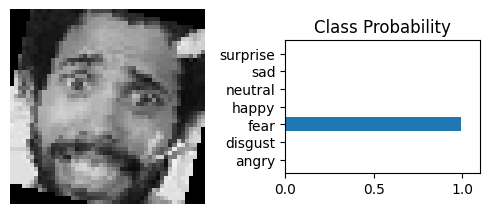

In [31]:
# Perform inference
model.eval()
with torch.no_grad():
	image = image.to(device)
	logits = model(image.unsqueeze(0))  # Add batch dimension
	probabilities = torch.nn.functional.softmax(logits, dim=1)

# Plot the image and class probabilities
view_classify(image.cpu(), probabilities)

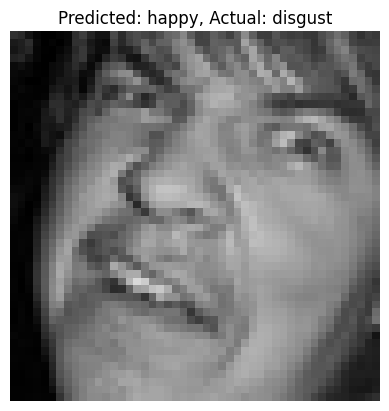

In [40]:
import random

# Select a random image from the validation dataset
random_idx = random.randint(0, len(validset) - 1)
random_image, random_label = validset[random_idx]

# Prepare the image for the model
random_image = random_image.to(device).unsqueeze(0)  # Add batch dimension

# Perform inference
model.eval()
with torch.no_grad():
	logits = model(random_image)
	probabilities = torch.nn.functional.softmax(logits, dim=1)
	predicted_class = probabilities.argmax(dim=1).item()

# Display the image and prediction
plt.imshow(random_image.cpu().squeeze().permute(1, 2, 0))
plt.title(f"Predicted: {predicted_class}, Actual: {random_label}")
plt.axis('off')
# Map numeric labels to emotion names
emotion_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
predicted_emotion = emotion_classes[predicted_class]
actual_emotion = emotion_classes[random_label]

plt.title(f"Predicted: {predicted_emotion}, Actual: {actual_emotion}")
plt.show()